In [1]:
cd("/home/htc/bzfsikor/code/OptImpSampling.jl/")
using Pkg; Pkg.activate(".")

  Activating project at `~/code/OptImpSampling.jl`


In [2]:
# In this notebook we analyse the convergence of different SDE solvers for the 
# Girsanov reweighting of the ISOKANN problem with optimal control
using Revise
using OptImpSampling, StochasticDiffEq, DiffEqNoiseProcess, Plots
using OptImpSampling: Doublewell, isokann, optcontrol, GirsanovSDE, girsanovsample, statify

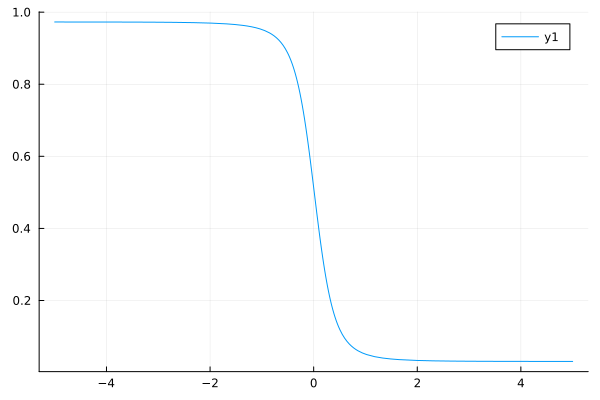

In [3]:
dynamics = Doublewell()
r = isokann(;dynamics);
plot(x->r.model([x])[1])

((s[1, :])[end], (s[end])[1:end - 1]) = (-1.3763406693660394, [-1.3763406693660394])
(ws[end], ws[end] * chis[end]) = (0.4899144654699328, 0.47204366359749245)


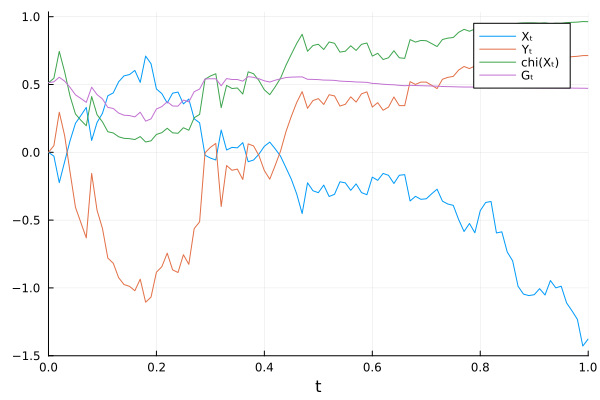

In [48]:
using Random
#Random.seed!(0)
sde = OptImpSampling.SDEProblem(dynamics, [0.])        # basic Doublewell SDE
u = optcontrol(statify(r.model), r.S, sde)                # compute the optimal control from the ISOKANN result
cde = GirsanovSDE(sde, u)
s = solve(cde, save_noise=true, alg=SROCK2())  # solve the girsanov SDE and save the noise
W0 = NoiseWrapper(s.W)                            # extract the noise for convergence analysis
plot(s, label=["Xₜ" "Yₜ"])
@show s[1,:][end], s[end][1:end-1]
chis = r.model(s[1,:]')'
ws = @. exp(-s[2,:])
@show ws[end], ws[end] * chis[end]
plot!(s.t, [chis chis .* ws], label=["chi(Xₜ)" "Gₜ"])

In [52]:
#Random.seed!(0)
@time x,w = girsanovsample(cde, 0.)
@show x,w
e = r.model(x)[1] * w

  0.000889 seconds (790 allocations: 94.266 KiB)
(x, w) = ([-0.7308377313532661], 0.5495279145143435)


0.5113111814765403

In [12]:
# Use a Brownian Tree to get reproducible noise for the convergence analysis of different solvers
W = VirtualBrownianTree(0.0, zeros(2); tree_depth = 5, tend=1.1)

prob = NoiseProblem(W, (0.0, 1.0))
@time sol = solve(prob; dt = 1e-6);

 17.334627 seconds (137.19 M allocations: 10.162 GiB, 13.02% gc time)


In [ ]:
logspace(min, max, n) = reverse(exp.(range(log(min), log(max), n)))
#W = deepcopy(W0)
W = VirtualBrownianTree(0.0, zeros(2); tree_depth=0, tend=1.1)
function plot_e_convergence!(;min=1e-7, max=1e-2, n=10, alg=EM())

    dts = logspace(min, max, n)
    
    e = map(dts) do  dt
        cde = GirsanovSDE(OptImpSampling.SDEProblem(Doublewell(), [0.], noise=W, alg=alg, dt=dt, abstol=dt, reltol=0.), u)
        @show alg, dt
        @time x,w = girsanovsample(cde, 0.)
        e = r.model(x)[1] * w
    end
    plot!(dts, e, xaxis=:log, label=Base.string(typeof(alg))[1:8])
end

plot()
time = @elapsed for alg in [EM(), LambaEM(), ImplicitEM(), SROCK2()]
    plot_e_convergence!(alg=alg)
end
plot!(xlabel="dt/abstol", ylabel="Z(T)")

In [54]:
savefig("sdeconvb.png")

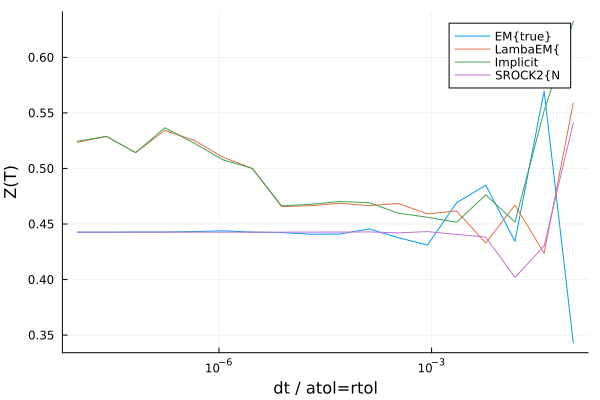

In [125]:
plot!()
xaxis!("dt / atol=rtol")